# Future Vision Transport : Design an Autonomous Vehicle

## Context

"Future Vision Transport" is a company building embedded computer vision systems for autonomous vehicles. 

The goal here is to build a model able to classify each pixel of an image into one of the given categories of objects, and expose this model's API as a web service.
This problem is known as "Semantic Segmentation" and is a challenge for the autonomous vehicle industry.

We will compare different models (varying architecture, augmentation method and image resizing) and their performances on the [Cityscapes dataset](https://www.cityscapes-dataset.com/). We will use AzureML and Azure App Service to deploy our models.


## Project modules

- other notebooks :
  - [train.ipynb](train.ipynb "train.ipynb") : orchestration of the models training process in AzureML
  - [deploy.ipynb](deploy.ipynb "deploy.ipynb") : orchestration of the models endpoint deployment process in AzureML
  - [predict.ipynb](predict.ipynb "predict.ipynb") : orchestration of the models prediction tests process in AzureML
- `notebooks/azureml/` : contains the code deployed in AzureML training and prediction environments.
- `webapp/` : contains the webapp deployed in Azure App Service.
- `src/` : contains the helpers functions and project specific code.


We will use the [Python](https://www.python.org/about/gettingstarted/) programming language, and present here the code and results in this [Notebook JupyterLab](https://jupyterlab.readthedocs.io/en/stable/getting_started/overview.html) file.

We will use the usual libraries for data exploration, modeling and visualisation :

- [NumPy](https://numpy.org/doc/stable/user/quickstart.html) and [Pandas](https://pandas.pydata.org/docs/user_guide/index.html) : for maths (stats, algebra, ...) and large data manipulation
- [Plotly](https://plotly.com/python/getting-started/) : for interactive data visualization

We will also use libraries specific to the goals of this project :

- [TensorFlow](https://www.tensorflow.org/versions/r1.12/get_started/index.html) and [Keras](https://keras.io/getting-started/sequential-model-guide/) : for deep learning
- Image processing :
  - [Pillow](https://pillow.readthedocs.io/en/stable/index.html) : for image manipulation
  - [OpenCV](https://docs.opencv.org/3.4.1/d4/da8/tutorial_py_image_arithmetics.html) : for image processing
  - [Albumentations](https://albumentations.ai/docs/#introduction-to-image-augmentation) : for image augmentation


In [1]:
from tqdm import tqdm
import base64
import json
import os
import time
from io import BytesIO
from pathlib import Path

import numpy as np
import requests
import tensorflow as tf
from dotenv import dotenv_values, load_dotenv
from matplotlib import pyplot as plt
from PIL import Image

import random
import azureml.cityscapes as cityscapes
from azureml.core import Model, Workspace

load_dotenv()
AZURE_SUBSCRIPTION_ID = os.getenv("AZURE_SUBSCRIPTION_ID")
AZURE_RESOURCE_GROUP = os.getenv("AZURE_RESOURCE_GROUP")
AZURE_WORKSPACE_NAME = os.getenv("AZURE_WORKSPACE_NAME")


2022-03-17 12:16:24.924957: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-17 12:16:24.924991: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Exploratory data analysis (EDA)

We are going to load the data and analyse the distribution of each variable.


### Load data

Let's download the data from the [Cityscapes](https://www.cityscapes-dataset.com/) dataset.


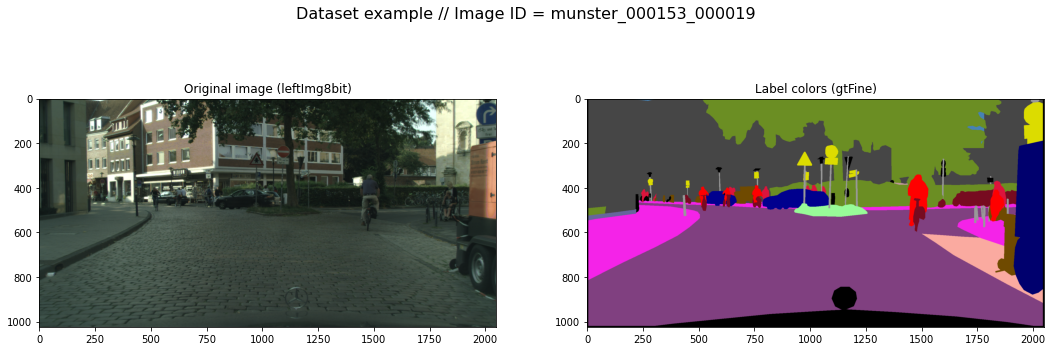

In [7]:
raw_data_path = Path("./../data/raw")
leftImg8bit_path = Path(raw_data_path, "leftImg8bit")
gtFine_path = Path(raw_data_path, "gtFine")

# Train dataset
train_input_img_paths = sorted(
    Path(leftImg8bit_path, "train").glob("**/*_leftImg8bit.png")
)
train_label_ids_img_paths = sorted(
    Path(gtFine_path, "train").glob("**/*_gtFine_labelIds.png")
)

# Validation dataset
val_input_img_paths = sorted(
    Path(leftImg8bit_path, "val").glob("**/*_leftImg8bit.png")
)
val_label_ids_img_paths = sorted(
    Path(gtFine_path, "val").glob("**/*_gtFine_labelIds.png")
)
val_label_colors_img_paths = sorted(
    Path(gtFine_path, "val").glob("**/*_color.png")
)


rand_idx = np.random.randint(0, len(val_input_img_paths))
image_id = (
    str(val_input_img_paths[rand_idx])
    .split("/")[-1]
    .replace("_leftImg8bit.png", "")
)


# plot images
fig, ax = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(18, 6),
)
fig.suptitle(f"Dataset example // Image ID = {image_id}", fontsize=16)

ax[0].title.set_text("Original image (leftImg8bit)")
ax[0].imshow(np.array(Image.open(val_input_img_paths[rand_idx])))

ax[1].title.set_text("Label colors (gtFine)")
ax[1].imshow(np.array(Image.open(val_label_colors_img_paths[rand_idx])))

plt.show()


100%|██████████| 500/500 [00:14<00:00, 34.37it/s]


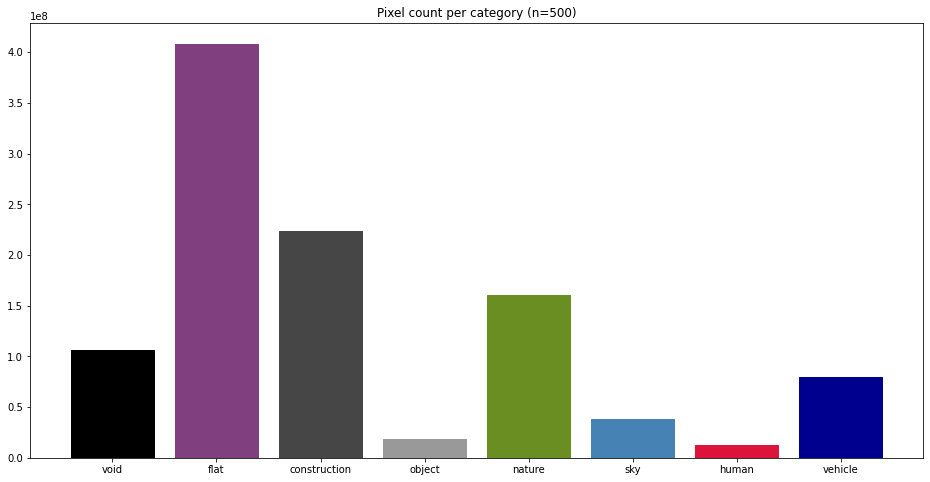

In [3]:
subset_size = 500
cat = np.array(
    [
        cityscapes.cityscapes_label_ids_to_category_ids(
            np.array(Image.open(img))
        )
        for img in tqdm(
            random.choices(train_label_ids_img_paths, k=subset_size)
        )
    ]
)
unique, counts = np.unique(cat.flatten(), return_counts=True)
hist = dict(zip(unique, counts))

for category in cityscapes.CITYSCAPES_CATEGORIES:
    try:
        hist[category.name] = hist.pop(category.id)
    except KeyError:
        hist[category.name] = 0

plt.figure(figsize=(18, 6))
barlist = plt.bar(hist.keys(), hist.values())

for category in cityscapes.CITYSCAPES_CATEGORIES:
    barlist[category.id].set_color(np.array(category.color_rgb) / 255)

plt.title(f"Pixel count per category (n={subset_size})")
plt.show()



In [ ]:
--------------

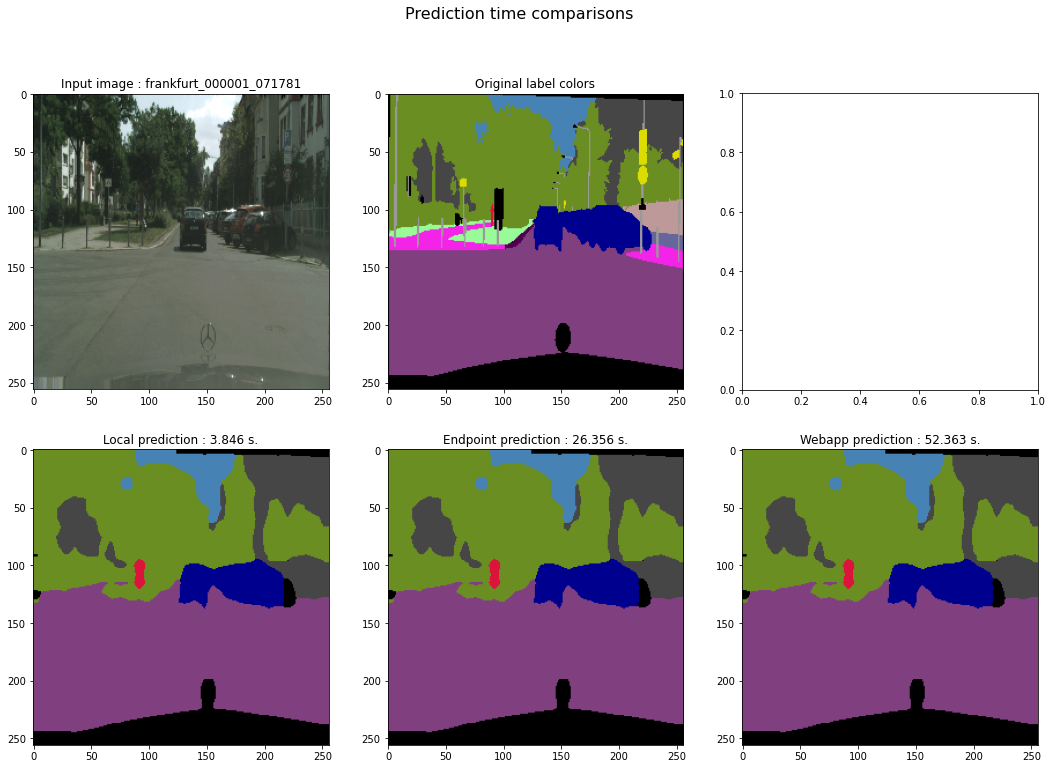

In [3]:

# Get the model
model_name = "deeplab_v3plus_256"
model_input_size = int(model_name.replace("_augment", "").split("_")[-1])
img_size = (model_input_size, model_input_size)



rand_idx = np.random.randint(0, len(val_input_img_paths))
image_id = (
    str(val_input_img_paths[rand_idx])
    .split("/")[-1]
    .replace("_leftImg8bit.png", "")
)


with open(val_input_img_paths[rand_idx], "rb") as f:
    im_read = f.read()
    im_b64 = base64.b64encode(im_read)
    im_b64_str = im_b64.decode("utf-8")

    im_binary = base64.b64decode(im_b64)
    im_bytes = BytesIO(im_binary)
    input_img = Image.open(im_bytes).resize(img_size)

    # Local model prediction
    model_path = Path("./../results/downlad/", model_name)
    if not Path(model_path, "model").exists():
        Model(
            Workspace(
                subscription_id=AZURE_SUBSCRIPTION_ID,
                resource_group=AZURE_RESOURCE_GROUP,
                workspace_name=AZURE_WORKSPACE_NAME,
            ),
            model_name,
        ).download(target_dir=model_path)

    model = tf.keras.models.load_model(
        Path(model_path, "model/data/model"),
        custom_objects={
            "UpdatedMeanIoU": cityscapes.UpdatedMeanIoU,
            "jaccard_loss": cityscapes.jaccard_loss,
        },
    )

    start = time.time()
    output_img = model.predict(np.expand_dims(input_img, 0))

    local_predict_time = time.time() - start
    local_output_mask = cityscapes.cityscapes_category_ids_to_category_colors(
        np.squeeze(
            np.argmax(model.predict(np.expand_dims(input_img, 0)), axis=-1)
        )
    )

    # AzureML registered model Endpoint prediction
    inference_config = dotenv_values(Path(f"../.env.{model_name}"))
    url = inference_config["AZURE_INFERENCE_ENDPOINT"]
    headers = {
        "Content-Type": "application/json",
        "Authorization": ("Bearer " + inference_config["AZURE_INFERENCE_KEY"]),
    }
    data = {"image": im_b64_str}
    payload = str.encode(json.dumps(data))
    r = requests.post(url, headers=headers, data=payload)
    result = r.content

    endpoint_predict_time = r.elapsed.total_seconds()
    endpoint_output_mask = Image.open(BytesIO(base64.b64decode(result)))

    # Flask WebApp prediction
    url = "https://ocp8-webapp.azurewebsites.net/api"
    headers = {
        "Content-Type": "application/json",
    }
    data = {"image_id": image_id}
    r = requests.get(url, headers=headers, params=data)
    predict_time = r.elapsed.total_seconds()
    result = json.loads(r.content)

    webapp_predict_time = r.elapsed.total_seconds()
    webapp_output_mask = Image.open(
        BytesIO(base64.b64decode(result["categories_img_b64_str"]))
    )

    # plot images
    fig, ax = plt.subplots(
        nrows=2,
        ncols=3,
        figsize=(18, 12),
    )
    fig.suptitle("Prediction time comparisons", fontsize=16)

    ax[0, 0].title.set_text("Input image : {}".format(image_id))
    val_img = tf.keras.utils.load_img(
        val_input_img_paths[rand_idx], target_size=img_size
    )
    ax[0, 0].imshow(val_img)

    ax[0, 1].title.set_text("Original label colors")
    val_colors = tf.keras.utils.load_img(
        val_label_colors_img_paths[rand_idx], target_size=img_size
    )
    ax[0, 1].imshow(val_colors)

    ax[0, 2].title.set_text("Original category colors")
    val_colors = tf.keras.utils.load_img(
        val_label_colors_img_paths[rand_idx], target_size=img_size
    )
    ax[0, 2].imshow(val_colors)

    ax[1, 0].title.set_text(
        "Local prediction : {} s.".format(round(local_predict_time, 3))
    )
    ax[1, 0].imshow(local_output_mask)

    ax[1, 1].title.set_text(
        "Endpoint prediction : {} s.".format(round(endpoint_predict_time, 3))
    )
    ax[1, 1].imshow(endpoint_output_mask)

    ax[1, 2].title.set_text(
        "Webapp prediction : {} s.".format(round(webapp_predict_time, 3))
    )
    ax[1, 2].imshow(webapp_output_mask)

    plt.show()
